# FIT5202 Data processing for big data

## Activity: Machine Learning with Spark (Logistic Regression)

Last week we learnt how to use machine learning pipeline and implement classification algorithm known as Naïve Bayes. You also worked on the exercise activity and implement Support Vector Machine (SVM). 

This week we will learn how to use logistic regression algorithm in Apache Spark for prediction. In this activity, our task is to :
- Use logistic regression to predict whether the client will subscribe (Yes/No) to a term deposit.
- Compare the result with decision tree. 
- Use boosting technique to improve the prediction.

The data can be downloaded from Moodle. 


<font color='blue'>

**What you need to remember**:
    
- Run your cells using SHIFT+ENTER (or "Run cell")
- Run the current cell and insert a new cell below: ALT+ENTER
- To see more commands, please click the "menu" option (e.g. "Insert", "Cell")
- To see more keyboard shortcuts, click the above "keyboard image" button. Use "Esc" to enter command mode. Then, you can use a command. Some of the popular shortcuts are 
    - Basic navigation: enter, shift-enter, up/k, down/j
    - Saving the notebook: s
    - Cell creation: a (above), b (below)

# Logistic Regression

*Logistic Regression* is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. To represent binary/categorical outcome, we use dummy variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.


## Include required libraries and load files

In [18]:
from pyspark import SQLContext, SparkConf, SparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession


sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[*]", appName="Linear Regression")
spark = SparkSession(sparkContext=sc)
    
sqlcontext = SQLContext(sc)

#load the file into variable. make sure you read the header and schema for the table
data = sqlcontext.read.csv('salary_data.csv', header=True, inferSchema=True )
#data = 

#display the schema for the data
data.printSchema()
data.show()


root
 |-- year: double (nullable = true)
 |-- salary: integer (nullable = true)

+----+------+
|year|salary|
+----+------+
| 1.1| 39343|
| 1.3| 46205|
| 1.5| 37731|
| 2.0| 43525|
| 2.2| 39891|
| 2.9| 56642|
| 3.0| 60150|
| 3.2| 54445|
| 3.2| 64445|
| 3.7| 57189|
| 3.9| 63218|
| 4.0| 55794|
| 4.0| 56957|
| 4.1| 57081|
| 4.5| 61111|
| 4.9| 67938|
| 5.1| 66029|
| 5.3| 83088|
| 5.9| 81363|
| 6.0| 93940|
+----+------+
only showing top 20 rows



 ### Preparing the data for training and testing

In [19]:
#Choose 2 columns from the data. Make the column for y axis as 'label'
dataset = data.select(data.year,data.salary.alias('label'))

#split the data into 70:30
#70% : training and 30%: testing
training,test = dataset.randomSplit([0.7,0.3],seed = 100)
assembler = VectorAssembler().setInputCols(['year',]).setOutputCol('features')

trainingSet = assembler.transform(training)
trainingSet2 = trainingSet.select("features","label")
trainingSet2.show(truncate=False)

+--------+------+
|features|label |
+--------+------+
|[1.1]   |39343 |
|[1.3]   |46205 |
|[1.5]   |37731 |
|[2.0]   |43525 |
|[2.9]   |56642 |
|[3.0]   |60150 |
|[3.9]   |63218 |
|[4.0]   |55794 |
|[4.0]   |56957 |
|[4.1]   |57081 |
|[4.5]   |61111 |
|[5.1]   |66029 |
|[5.3]   |83088 |
|[6.8]   |91738 |
|[7.9]   |101302|
|[8.2]   |113812|
|[8.7]   |109431|
|[9.6]   |112635|
|[10.3]  |122391|
|[10.5]  |121872|
+--------+------+



In [20]:
#Define Linear Regression training step with 10 iterations
lr = LinearRegression(maxIter = 10)
lr_Model = lr.fit(trainingSet2)


#Test the model using testing dataset
testSet1 = assembler.transform(test)
testSet2 = testSet1.select("features","label")
testSet3 = lr_Model.transform(testSet2)

#testSet3.show(truncate=False)
#Display the result with error value
result1 = testSet3.select("features","label","prediction",(testSet3.prediction - testSet3.label).alias("err"))

result1.show(truncate=False)
#result1.withColumn("error",abs(result1.err)).show(truncate=False)


+--------+------+------------------+-------------------+
|features|label |prediction        |err                |
+--------+------+------------------+-------------------+
|[2.2]   |39891 |46633.40121986039 |6742.401219860389  |
|[3.2]   |54445 |55980.79785252584 |1535.7978525258368 |
|[3.2]   |64445 |55980.79785252584 |-8464.202147474163 |
|[3.7]   |57189 |60654.49616885856 |3465.496168858561  |
|[4.9]   |67938 |71871.37212805709 |3933.37212805709   |
|[5.9]   |81363 |81218.76876072254 |-144.231239277462  |
|[6.0]   |93940 |82153.50842398909 |-11786.491576010914|
|[7.1]   |98273 |92435.64471992107 |-5837.355280078933 |
|[9.0]   |105582|110195.69832198542|4613.6983219854155 |
|[9.5]   |116969|114869.39663831814|-2099.6033616818604|
+--------+------+------------------+-------------------+



In [36]:
#Load forecast dataset
forecast = sqlcontext.read.csv('salary_forecast.csv', header=True, inferSchema=True )

forecast_data = forecast.select(forecast.year,forecast.salary.alias('label'))

#Predict the forecast unlabeled value
forecast_result1 = assembler.transform(forecast_data)
forecast_result2 = forecast_result1.select("features", "label")
forecast_result3 = lr_Model.transform(forecast_result2)

result2 = forecast_result3.select("features","prediction")

result2.show(truncate=False)

+--------+------------------+
|features|prediction        |
+--------+------------------+
|[12.0]  |138237.88821998175|
|[15.0]  |166280.07811797806|
|[20.0]  |213017.06128130533|
+--------+------------------+



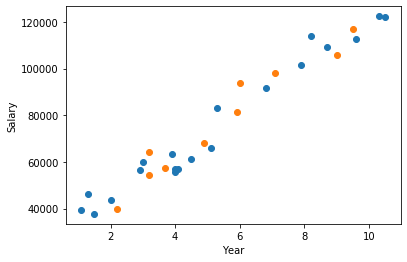

In [40]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xtrain = [row['year'] for row in training.collect()]
ytrain = [row['label'] for row in training.collect()]

xtest = [row['year'] for row in test.collect()]
ytest = [row['label'] for row in test.collect()]

plt.scatter(xtrain, ytrain, c = 'C0', label = 'Training')
plt.scatter(xtest, ytest, c = 'C1', label = 'Testing')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

### Congratulations on finishing you activity for this week.